In [1]:
import os
import glob
import lasio
import segyio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# File path to the CSV
path = r'C:\Users\sushila\Desktop\Data_shared_with Participants\Wells_LAS_Points.csv'

# Load the data
df = pd.read_csv(path)

# Rename columns and clean up well identifiers
df.rename(columns={'depth': 'Depth'}, inplace=True)
df['holeid'] = df['holeid'].str.replace('-', '_')

# Group data by 'holeid' and create individual DataFrames for each well
for holeid, group in df.groupby('holeid'):
    variable_name = f"df_{holeid}"
    globals()[variable_name] = group
    print(f"Created DataFrame: {variable_name}")

# Remove rows with NaN in 'TEMP' and 'AC' columns
df_cleaned_temp = df.dropna(subset=['TEMP'])
df_cleaned_ac = df.dropna(subset=['AC'])


# Find unique wells with valid 'TEMP' and 'AC' values
wells_with_temp = df_cleaned_temp['holeid'].unique()
wells_with_ac = df_cleaned_ac['holeid'].unique()


# Print the results
print("Wells with valid 'TEMP' values:", wells_with_temp)
print("Wells with valid 'AC' values:", wells_with_ac)



Created DataFrame: df_LONCCARICA_1
Created DataFrame: df_REZOVACCKE_KRCCEVINE_1
Created DataFrame: df_REZOVACCKE_KRCCEVINE_2
Created DataFrame: df_SUHOPOLJE_1
Created DataFrame: df_VIROVITICA_1
Created DataFrame: df_VIROVITICA_3ALFA
Wells with valid 'TEMP' values: ['LONCCARICA_1' 'REZOVACCKE_KRCCEVINE_1' 'VIROVITICA_1']
Wells with valid 'AC' values: ['REZOVACCKE_KRCCEVINE_1' 'SUHOPOLJE_1' 'VIROVITICA_3ALFA']


In [2]:
"""There is more information in las files. The provided CSV file do not contain all the
      information from the las files .So lets load las files"""
import os
import glob
import lasio
import pandas as pd

# Define the main folder path containing the subfolders
main_folder_path = r'C://Users/sushila/Desktop/Data_shared_with Participants/Data/Wells/LAS and Reports\Suhopolje-1\Las_files'

# Find all LAS files in the Las_files folder
las_files = glob.glob(os.path.join(main_folder_path, "*.las"))

# Create an empty list to store DataFrames
las_dataframes = []

# Track all unique depth values
all_depths = set()

# Loop through each LAS file and read it
for las_file in las_files:
    try:
        # Read the LAS file
        las_data = lasio.read(las_file)
            
        # Convert the LAS file to a DataFrame
        las_df = las_data.df()
            
        # Standardize the depth column name by resetting index and renaming
        las_df.reset_index(inplace=True)  # Bring depth from index to column if needed
        depth_column = next((col for col in las_df.columns if col.lower() == 'depth' or col.lower() == 'dept'), None)

        if depth_column:
            las_df.rename(columns={depth_column: 'Depth'}, inplace=True)
        else:
            raise ValueError("Depth column not found in LAS file")

        # Update the set of all depth values
        all_depths.update(las_df['Depth'].unique())

        # Append this DataFrame to the list
        las_dataframes.append(las_df)

    except Exception as e:
        print(f"Error reading {las_file}: {e}")

# If there are LAS DataFrames, merge them
if las_dataframes:
    # Create a complete depth DataFrame
    all_depths_df = pd.DataFrame(sorted(all_depths), columns=['Depth'])

    # Align each DataFrame to the complete depth range and merge
    for i, las_df in enumerate(las_dataframes):
        las_dataframes[i] = pd.merge(all_depths_df, las_df, on='Depth', how='left')

    # Concatenate all aligned DataFrames
    las_df = pd.concat(las_dataframes, axis=1)

    # Combine duplicate columns and calculate averages for existing values
    def combine_columns(df):
        combined_df = pd.DataFrame()
        for col in df.columns:
            # Identify columns with the same name
            matching_cols = [c for c in df.columns if c == col]
            if len(matching_cols) > 1:  # If there are duplicate columns with the same name
                # Calculate the mean of the columns, prioritizing non-NaN values
                combined_df[col] = df[matching_cols].mean(axis=1, skipna=True)
            else:
                # If there's no duplicate, just keep the original column
                combined_df[col] = df[col]

        return combined_df


    las_df = combine_columns(las_df)

    # Drop duplicate depth rows and sort
    las_df = las_df.drop_duplicates(subset=['Depth']).sort_values(by='Depth')

    # Set Depth as the index
    las_df.set_index('Depth', inplace=True)

    # Reset index, which will bring Depth back as a column
    las_df.reset_index(inplace=True)

else:
    las_df = pd.DataFrame()  # Empty DataFrame if no LAS files were found

# Display the final DataFrame with Depth as both column and index
las_df


,Depth,AC,SP,GR,CAL,CN,CORR,DEN,RD,RS,BS,RLML,RNML,R16,R64
0,215.0,139.502,NaN,15.43200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215.1,139.502,NaN,15.43200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215.2,139.502,NaN,15.43200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215.3,139.502,NaN,15.43200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215.4,139.502,NaN,15.43200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47696,4984.6,66.048,50.07775,61.80200,7.715,15.777,-0.0785,2.506,10.991,21.332,8.5,NaN,NaN,29.131,63.595
47697,4984.7,66.048,49.90350,61.64400,7.699,15.896,-0.0770,2.506,10.991,21.332,8.5,NaN,NaN,29.405,64.143
47698,4984.8,66.248,49.70375,61.22350,7.687,16.135,-0.0750,2.507,10.991,21.332,8.5,NaN,NaN,29.655,64.692
47699,4984.9,66.447,49.60725,60.73975,7.683,16.135,-0.0740,2.507,10.991,21.332,8.5,NaN,NaN,29.849,65.006


In [3]:
las_df.columns


Index(['Depth', 'AC', 'SP', 'GR', 'CAL', 'CN', 'CORR', 'DEN', 'RD', 'RS', 'BS',
       'RLML', 'RNML', 'R16', 'R64'],
      dtype='object')

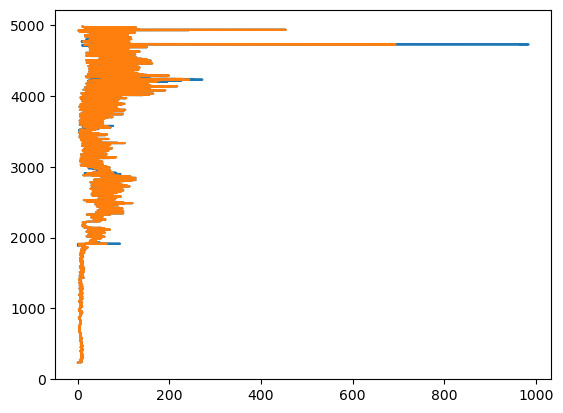

In [4]:
plt.plot(df_SUHOPOLJE_1['RD'],df_SUHOPOLJE_1['Depth'])
plt.plot(las_df['RD'],las_df['Depth'])

In [5]:
def preprocess_data(df):
    """
    Preprocess the DataFrame by removing rows with NaN in 'AC'
    and keeping rows where 'AC' >= 1.
    """
    return df.dropna(subset=['AC']).query('AC >= 1')

def calculate_sonic_velocity(df):
    """
    Add a new column 'Sonic_velocity' based on the 'AC' column.
    """
    df['Sonic_velocity'] = 1 / df['AC'] * 10**6 * 0.3048
    return df

def interpolate_and_extrapolate(df, final_depth=5000, delta_depth=0.1):
    """
    Interpolate and extrapolate depths and velocities.
    """
    # Extract first and last depth and velocity
    depth_1, vel_1 = df['Depth'].iloc[0], df['Sonic_velocity'].iloc[0]
    depth_2, vel_2 = df['Depth'].iloc[-1], df['Sonic_velocity'].iloc[-1]

    # Interpolate depths and velocities
    interp_depths = np.arange(0, depth_1 + delta_depth, delta_depth)
    interp_velocities = vel_1 + (vel_2 - vel_1) * (interp_depths - depth_1) / (depth_2 - depth_1)

    # Extrapolate depths and velocities
    extrap_depths = np.arange(depth_2 + delta_depth, final_depth + delta_depth, delta_depth)
    slope = (vel_2 - vel_1) / (depth_2 - depth_1)
    extrap_velocities = vel_2 + slope * (extrap_depths - depth_2)

    # Combine interpolated and extrapolated values
    all_depths = np.concatenate([interp_depths, extrap_depths])
    all_velocities = np.concatenate([interp_velocities, extrap_velocities])

    return pd.DataFrame({'Depth': all_depths, 'Sonic_Velocity': all_velocities})

def calculate_travel_time(df, delta_depth=0.1):
    """
    Calculate cumulative travel time based on Sonic_Velocity.
    """
    velocities = df['Sonic_Velocity'].values
    time_intervals = 2 * (delta_depth / velocities)  # Two-way travel time
    df['Cumulative_Time'] = np.cumsum(time_intervals)
    return df

def merge_well_data(combined_df, original_df, columns_to_add):
    """
    Merge additional well data columns into the combined DataFrame.
    """
    columns_in_original = [col for col in columns_to_add if col in original_df.columns]
    return pd.merge(
        combined_df,
        original_df[['Depth'] + columns_in_original],
        on='Depth',
        how='left'
    )

def resample_data(df, time_col='Cumulative_Time', interval=0.001):
    """
    Resample data to uniform time intervals.
    """
    new_time_values = np.arange(df[time_col].min(), df[time_col].max() + interval, interval)
    new_time_values = np.round(new_time_values, 3)
    resampled_df = pd.DataFrame({'Time (s)': new_time_values})

    for column in df.columns:
        if column != time_col:
            resampled_df[column] = np.interp(new_time_values, df[time_col], df[column])

    return resampled_df

# Main pipeline
def process_well_data(df, final_depth=5000, delta_depth=0.1, resample_interval=0.001):
    """
    Complete pipeline for processing well data.
    """
    # Preprocess data
    df = preprocess_data(df)

    # Calculate Sonic Velocity
    df = calculate_sonic_velocity(df)

    # Select relevant columns
    well_data_selected = df[['Depth', 'AC', 'Sonic_velocity']].copy()

    # Interpolate and extrapolate
    interpolated_df = interpolate_and_extrapolate(well_data_selected, final_depth, delta_depth)

    # Combine with original data
    combined_df = pd.concat([interpolated_df, well_data_selected.rename(columns={'Depth': 'Depth'})], ignore_index=True)
    combined_df = combined_df.sort_values(by='Depth').reset_index(drop=True)

    # Combine Sonic Velocity columns if needed
    if 'Sonic_velocity' in df.columns and 'Sonic_Velocity' in combined_df.columns:
        combined_df['Sonic_Velocity'] = combined_df['Sonic_Velocity'].fillna(combined_df['Sonic_velocity'])
        combined_df.drop(columns=['Sonic_velocity'], inplace=True)

    # Calculate travel time
    combined_df = calculate_travel_time(combined_df)

    # Merge additional well data columns
    columns_to_add = ['R64', 'RD']
    combined_df = merge_well_data(combined_df, df, columns_to_add)

    # Rename cumulative time column
    combined_df.rename(columns={'Cumulative_Time': 'Time (s)'}, inplace=True)

    # Resample data
    resampled_df = resample_data(combined_df, time_col='Time (s)', interval=resample_interval)

    return resampled_df

# Run pipeline
resampled_df = process_well_data(las_df)
resampled_df

,Time (s),Depth,Sonic_Velocity,AC,R64,RD
0,0.000,0.000000,2076.639666,NaN,NaN,NaN
1,0.001,0.938438,2077.112269,NaN,NaN,NaN
2,0.002,1.977138,2077.635364,NaN,NaN,NaN
3,0.003,3.016099,2078.158591,NaN,NaN,NaN
4,0.004,4.055322,2078.681950,NaN,NaN,NaN
...,...,...,...,...,...,...
3116,3.116,4992.034592,4590.657204,NaN,NaN,NaN
3117,3.117,4994.330223,4591.813297,NaN,NaN,NaN
3118,3.118,4996.626431,4592.969680,NaN,NaN,NaN
3119,3.119,4998.923218,4594.126355,NaN,NaN,NaN


Match found at index 784: x = 693135, y = 5073705
Trace found at index 784.


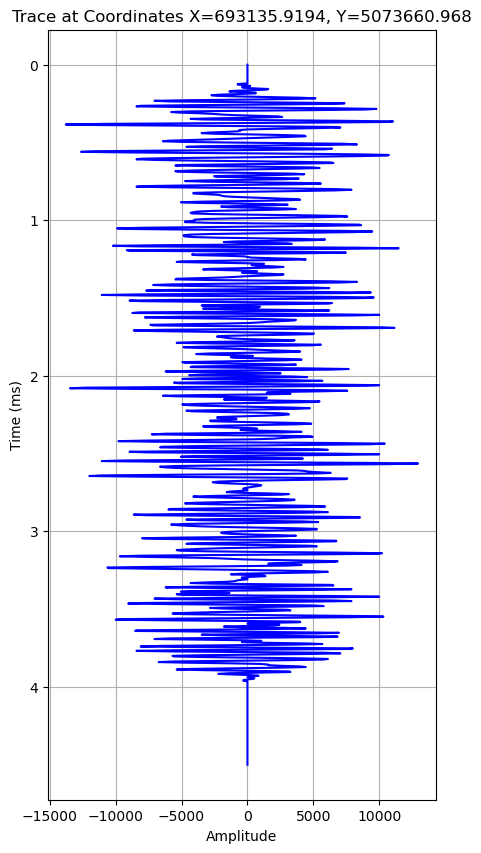

In [6]:
import segyio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path to SEG-Y file
path = 'C://Users/sushila/Desktop/Data_shared_with Participants/Data/2D Seismic/Suhopolje 1/VIR-17V-82_01._KNGD export.sgy'

# Coordinates to search for
target_x = 693135.9194
target_y = 5073660.968
target_z = 113.7333835

# Read and extract data
with segyio.open(path, "r", strict=False) as f:
    f.mmap()  # Memory map the file for efficient access

    # Extract coordinates from headers
    source_x = np.array(f.attributes(segyio.TraceField.SourceX))
    source_y = np.array(f.attributes(segyio.TraceField.SourceY))

    # Find the trace index that matches the given coordinates (allowing for floating-point precision)
    trace_index = None
    for i, (x, y) in enumerate(zip(source_x, source_y)):
        if np.isclose(x, target_x, atol=1e-3) and np.isclose(y, target_y, atol=1e-3): 
            print(f"Match found at index {i}: x = {x}, y = {y}")
            trace_index = i
            break

    if trace_index is None:
        print("No trace found with the given coordinates.")
        trace_data = None
    else:
        print(f"Trace found at index {trace_index}.")
        # Extract the trace data
        trace_data = f.trace[trace_index]
        
        # Retrieve sampling interval (in ms) and calculate time axis
        dt = segyio.dt(f) / 1000  # Convert to milliseconds
        time_axis = np.arange(len(trace_data)) * dt

# Convert time from milliseconds to seconds
time_axis_seconds = time_axis / 1000  # Now the time is in seconds

# Create a DataFrame with trace amplitude and time
if trace_data is not None:
    df_trace = pd.DataFrame({
        "Time (s)": time_axis_seconds,
        "Amplitude": trace_data
    })

    
    # Plot the selected trace
    plt.figure(figsize=(5, 10))
    plt.plot(df_trace["Amplitude"], df_trace["Time (s)"], color="blue")
    plt.gca().invert_yaxis()  # Invert y-axis to show time increasing downward
    plt.xlabel("Amplitude")
    plt.ylabel("Time (ms)")
    plt.title(f"Trace at Coordinates X={target_x}, Y={target_y}")
    plt.grid()
    plt.show()


In [7]:
def instantaneous_frequency(seismic_data, sample_rate=4):
    # Compute the analytic signal using Hilbert Transform
    analytic_signal = hilbert(seismic_data)
    
    # Compute the instantaneous phase (angle of analytic signal)
    instantaneous_phase = np.angle(analytic_signal)
    
 
    # compute the derivative and multiply by the sample rate (in Hz)
    phase_derivative = np.diff(instantaneous_phase)  # First derivative of phase
    fs = 1000 / sample_rate  # Convert sample rate to Hz (1/sample_rate in seconds)
    instantaneous_freq = np.abs(phase_derivative) * fs / (2 * np.pi)  # Frequency in Hz
    
    return instantaneous_freq

# Calculate instantaneous frequency
instantaneous_freq = instantaneous_frequency(trace_data, sample_rate=4)
print(len(instantaneous_freq))

# Add NaN to the start to align the length
instantaneous_freq_full = np.concatenate(([np.nan], instantaneous_freq))

df_trace['Instantaneous_freq'] = instantaneous_freq_full
df_trace

1125


,Time (s),Amplitude,Instantaneous_freq
0,0.000,0.0,NaN
1,0.004,0.0,0.002305
2,0.008,0.0,0.001603
3,0.012,0.0,0.000432
4,0.016,0.0,0.001247
...,...,...,...
1121,4.484,0.0,0.001821
1122,4.488,0.0,0.002523
1123,4.492,0.0,0.000479
1124,4.496,0.0,0.000204


In [8]:
# # Define the desired time interval for resampling
# desired_time_interval = 0.001  # in seconds

# # Ensure the 'Time' column is sorted
# df_trace = df_trace.sort_values(by='Time (s)').reset_index(drop=True)

# # Generate the new time values with the desired interval
# new_time_values = np.arange(df_trace['Time (s)'].min(), df_trace['Time (s)'].max() + desired_time_interval, desired_time_interval)

# # Interpolate amplitude values to match the new time values
# resampled_df_trace = pd.DataFrame({
#     'Time (s)': new_time_values,
#     'Amplitude': np.interp(new_time_values, df_trace['Time (s)'], df_trace['Amplitude']),
#     'Instantaneous_freq': np.interp(new_time_values, df_trace['Time (s)'], df_trace['Instantaneous_freq'])
# })


# resampled_df_trace


In [9]:
# Initialize variables to store the results
first_non_zero_value = None
first_non_zero_index = None

# Iterate over the data
for index, value in enumerate(df_trace['Amplitude']):
    if value != 0:  # Check if the value is non-zero
        first_non_zero_value = value
        first_non_zero_index = index
        break  # Exit the loop once the first non-zero value is found

# Now, the values are stored in the variables
print(f"First non-zero value: {first_non_zero_value} at index {first_non_zero_index}")


First non-zero value: -736.3505859375 at index 31


In [10]:
resampled_df_trace1 = df_trace[first_non_zero_index:]
resampled_df_trace1

,Time (s),Amplitude,Instantaneous_freq
31,0.124,-736.350586,38.804558
32,0.128,-736.350586,210.326462
33,0.132,-210.385742,31.160084
34,0.136,210.385742,38.127804
35,0.140,105.192383,80.958725
...,...,...,...
1121,4.484,0.000000,0.001821
1122,4.488,0.000000,0.002523
1123,4.492,0.000000,0.000479
1124,4.496,0.000000,0.000204


In [11]:
# Perform an inner join on the 'Time (s)' column to keep only common time values
merged_df = pd.merge(resampled_df, resampled_df_trace1, on="Time (s)", how="inner")
# Feature Engineering
merged_df ['Amplitude_abs'] = merged_df ['Amplitude'].abs()  # Absolute value
merged_df ['Amplitude_roll_mean'] = merged_df ['Amplitude'].rolling(window=5, min_periods=1).mean()  # Rolling mean
merged_df ['Amplitude_energy'] = merged_df ['Amplitude'] ** 2  # Energy
merged_df

,Time (s),Depth,Sonic_Velocity,AC,R64,RD,Amplitude,Instantaneous_freq,Amplitude_abs,Amplitude_roll_mean,Amplitude_energy
0,0.124,130.681201,2142.451476,NaN,NaN,NaN,-736.350586,38.804558,736.350586,-736.350586,5.422122e+05
1,0.128,134.968313,2144.610490,NaN,NaN,NaN,-736.350586,210.326462,736.350586,-736.350586,5.422122e+05
2,0.132,139.259745,2146.771680,NaN,NaN,NaN,-210.385742,31.160084,210.385742,-561.028971,4.426216e+04
3,0.136,143.555502,2148.935048,NaN,NaN,NaN,210.385742,38.127804,210.385742,-368.175293,4.426216e+04
4,0.140,147.855587,2151.100596,NaN,NaN,NaN,105.192383,80.958725,105.192383,-273.501758,1.106544e+04
...,...,...,...,...,...,...,...,...,...,...,...
745,3.104,4958.408039,5231.450492,58.263000,53.069410,25.160430,525.963867,23.243084,525.963867,3092.670898,2.766380e+05
746,3.108,4969.792837,6183.148657,49.295327,58.751794,68.856282,-1893.472656,20.319656,1893.472656,2398.397656,3.585239e+06
747,3.112,4982.574909,6936.706748,43.941705,64.375382,11.189498,-3471.366211,17.231932,3471.366211,757.388477,1.205038e+07
748,3.116,4992.034592,4590.657204,NaN,NaN,NaN,-4628.488281,16.262177,4628.488281,-1220.238086,2.142290e+07


In [12]:
#Get the last depth value from las_df
last_depth = las_df['Depth'].values[-1]

# Assuming merged_df['Depth'] contains depth values sorted in ascending order
nearest_depth_idx = (merged_df['Depth'] - last_depth).abs().argmin()
nearest_depth = merged_df['Depth'].iloc[nearest_depth_idx]

# All rows starting from the nearest depth onward
cropped_merged_df = merged_df[merged_df['Depth'] <= nearest_depth]

# Step 4: Save the cropped dataframe to a CSV
cropped_merged_df.to_csv('SUHOPOLJE_1_ALL.csv', index=False)

In [13]:
import numpy as np

# Select the columns you need
merged_df_RT = merged_df[['Time (s)', 'Depth', 'RD', 'Amplitude', 'Instantaneous_freq', 'Amplitude_abs', 'Amplitude_roll_mean', 'Amplitude_energy']]

# Make a copy to avoid the SettingWithCopyWarning
merged_df_RT = merged_df_RT.copy()

# Drop rows with NaN values
merged_df_RT.dropna(inplace=True)

# Identify and remove outliers in the 'RD' column using the IQR method
Q1 = merged_df_RT['RD'].quantile(0.25)  # First quartile
Q3 = merged_df_RT['RD'].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows where 'RD' is an outlier
merged_df_RT = merged_df_RT[(merged_df_RT['RD'] >= lower_bound) & (merged_df_RT['RD'] <= upper_bound)]

# Reset the index after removing outliers
merged_df_RT.reset_index(drop=True, inplace=True)

# Save the cleaned DataFrame to a CSV file
merged_df_RT.to_csv('C://Users/sushila/Desktop/Hackathon/SUHOPOLJE_1_RT.csv', index=False)

# Optionally, print a confirmation message
print("Outliers removed and CSV file saved successfully!")

# Display the final DataFrame
merged_df_RT


Outliers removed and CSV file saved successfully!


,Time (s),Depth,RD,Amplitude,Instantaneous_freq,Amplitude_abs,Amplitude_roll_mean,Amplitude_energy
0,0.216,239.485907,6.486229,5154.449219,26.959469,5154.449219,1577.892383,2.656835e+07
1,0.220,243.408495,6.503000,3786.944336,27.273947,3786.944336,2798.130078,1.434095e+07
2,0.224,246.993992,6.266000,105.192383,27.575306,105.192383,2945.400195,1.106544e+04
3,0.228,250.531114,5.818000,-4418.101562,28.573803,4418.101562,1725.162695,1.951962e+07
4,0.232,253.921576,5.938867,-7047.921875,29.237514,7047.921875,-483.887500,4.967320e+07
...,...,...,...,...,...,...,...,...
680,3.088,4913.948748,12.612181,1577.893555,32.459068,1577.893555,-1998.665625,2.489748e+06
681,3.100,4946.589026,26.555668,3366.172852,25.790991,3366.172852,2524.629297,1.133112e+07
682,3.104,4958.408039,25.160430,525.963867,23.243084,525.963867,3092.670898,2.766380e+05
683,3.108,4969.792837,68.856282,-1893.472656,20.319656,1893.472656,2398.397656,3.585239e+06


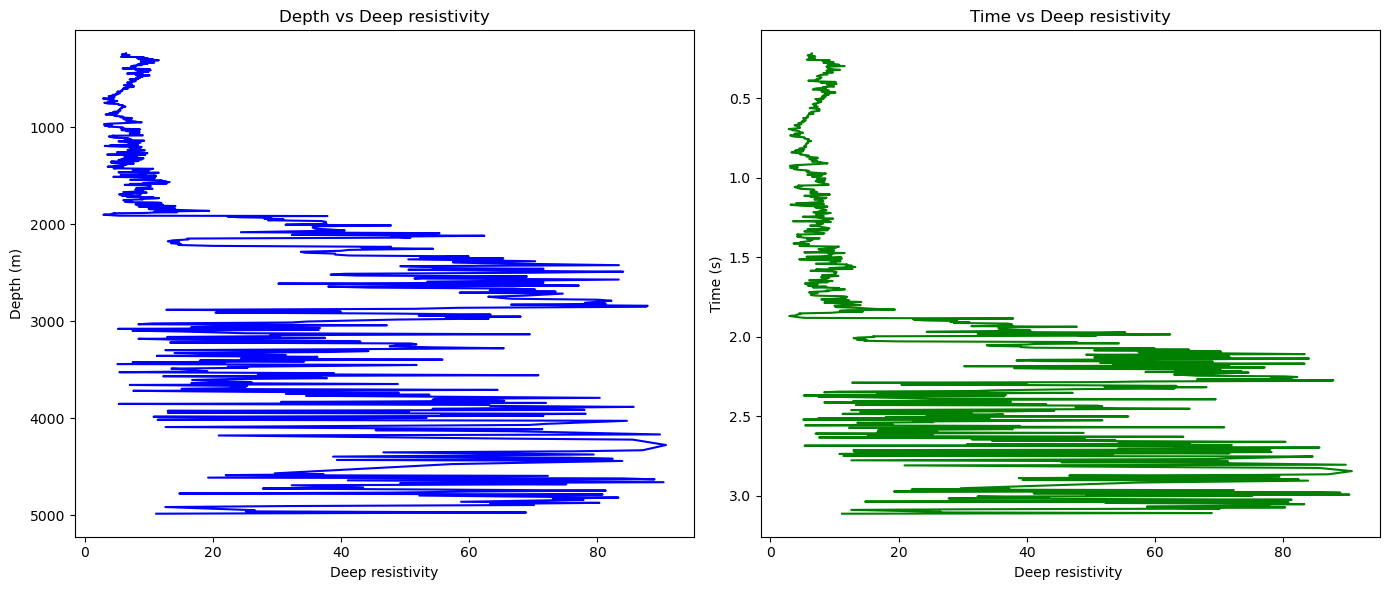

In [14]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#  first subplot
axes[0].plot(merged_df_RT['RD'], merged_df_RT['Depth'], color='blue')
axes[0].set_xlabel('Deep resistivity')
axes[0].set_ylabel('Depth (m)')
axes[0].invert_yaxis()  # Invert the y-axis to have depth increase downwards
axes[0].set_title('Depth vs Deep resistivity')

#  second subplot
axes[1].plot(merged_df_RT['RD'], merged_df_RT['Time (s)'] , color='green')
axes[1].set_xlabel('Deep resistivity ')
axes[1].set_ylabel('Time (s)')
axes[1].invert_yaxis() 
axes[1].set_title('Time vs Deep resistivity')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()
